# Predicción de Diabetes con regresión logística

### Pasos de este estudio
1. Carga de datos
1. Desarrollo

# 1. Carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\MedNo\AppData\Local\Temp\ipykernel_9196\3538350959.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# https://www.kaggle.com/datasets/kandij/diabetes-dataset
# lectura de datos en Python
train = pd.read_csv('./diabetes.csv')

In [3]:
train.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


Variables de interes:
* BMI: índice de masa corporal. Es una métrica o KPI basada en el peso y la altura de cada persona. Un BMI muy alto puede ser indicativo de tener diabetes
* Outcome: si la persona tiene diabetes o no

# 2. Desarrollo

En esta parte nos interesa explorar los datos y explicar el modelo de regresión logística a este caso de diabetes

## 2.1 Exploración de datos

Miramos una tabla y una gráfica de los datos que nos interesan

In [4]:
train[['BMI','Outcome']].head()

,BMI,Outcome
0,33.6,1
1,26.6,0
2,23.3,1
3,28.1,0
4,43.1,1


<Axes: xlabel='BMI', ylabel='Outcome'>

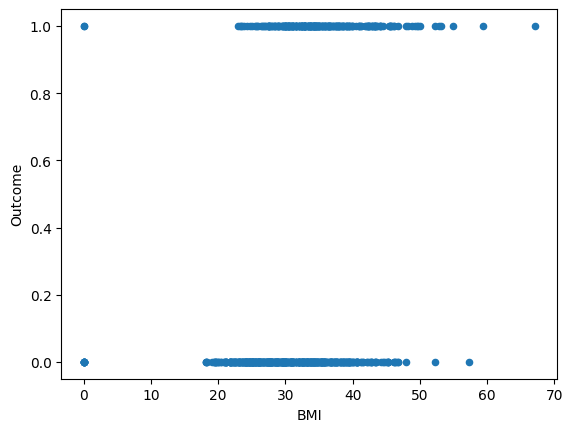

In [5]:
train[['BMI','Outcome']].plot.scatter(x='BMI',y='Outcome')

## 2.2 Función logística

Vamos a pintar una función logistica sobre estos datos

$$ f_{w,b}\left(\vec{x}^{(i)}\right)=\frac{1}{1+\exp-\left(w\vec{x}+b\right)}$$
Vamos a variar $w,b$ a ver que pasa en los datos

In [6]:
# pruebas de parametro
w = 0.09
b = -3.6

In [7]:
# despues de hacer el modelos (se explica más adelante)
# intercepto (b): [-3.68596089]
# pendiente (w): [[0.09351691]]

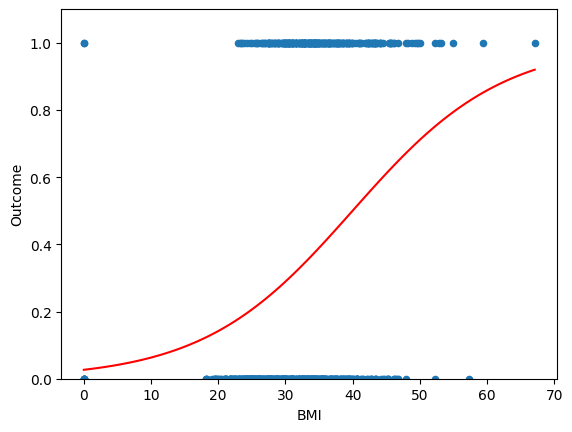

In [8]:
# puntos de la recta
x = np.linspace(0,train['BMI'].max(),100)
y = 1/(1+np.exp(-(w*x+b)))

# grafica de la recta
train.plot.scatter(x='BMI',y='Outcome')
plt.plot(x, y, '-r')
plt.ylim(0,train['Outcome'].max()*1.1)
# plt.grid()
plt.show()


## 2.3 Optimización de parámetros

Si escogemos esos parametros $w,b$ para el modelo, ¿Qué tan buenos son?

Podemos utilizar la siguiente estrategia:
* calcular el valor de la función logística para cada dato
* calcular la función de pérdida (se denota con L o loss)
* calcular el promedio de la pérdida para obtener el costo (se denota con Jo cost)

Queremos los valores $w,b$ que resulten en un menor costo

Las ecuaciones para las funciones son

$$ L\left(f_{w,b}\left(\vec{x}^{(i)}\right),y^{(i)}\right)=-y^{(i)}\log\left(f_{w,b}\left(\vec{x}^{(i)}\right)\right)-\left(1-y^{(i)}\right)\log\left(1-f_{w,b}\left(\vec{x}^{(i)}\right)\right) $$

$$ J\left(w,b\right)=\frac{1}{m}\sum_{i=1}^{m}\left[L\left(f_{w,b}\left(\vec{x}^{(i)}\right),y^{(i)}\right)\right] $$


In [9]:
# calculo de las predicciones
train['sigmoid'] = 1/(1+np.exp(-(train['BMI']*w+b)))

# calculo de la funcion de error
train['loss_xi'] = -train['Outcome']*np.log(train['sigmoid'])-(1-train['Outcome'])*np.log(1-train['sigmoid'])
cost_j = train['loss_xi'].mean()
cost_j

0.5995794663996212

Esto lo hemos hecho con los parametros que hemos obtenido a ojo por ciento. Ahora vamos a ser más refinados y calcularlo para muchos parametros a la vez y luego de ahi mirar el que tenga menor costo.

Para eso hacemos lo siguiente:
* Construimos un dataframe con valores para $w,b$ que varían sobre una cuadricula o grid
* Creamos una función de python que calcule el costo $J$ dados parametros $w,b$
* Aplicamos la función sobre el dataframe con los valores $w,b$ en la cuadricula
* Podemos ordenar la tabla resultante para obtener los valores $w,b$ con el menor costo
* Luego hacemos gráficas para verificar el resultado

In [10]:
# hacemos dataframe para calcular el error en funcion de los parametros w, b

In [11]:
array = np.mgrid[0.05:0.15:0.01, -4:-3:0.01].reshape(2,-1).T
df = pd.DataFrame(data = array, 
                  columns = ['w','b'])

# round para solventar problema con muchos decimales
df['w'] = np.round(df['w'], 6)
df['b'] = np.round(df['b'], 6)

In [12]:
df

,w,b
0,0.05,-4.00
1,0.05,-3.99
2,0.05,-3.98
3,0.05,-3.97
4,0.05,-3.96
...,...,...
995,0.14,-3.05
996,0.14,-3.04
997,0.14,-3.03
998,0.14,-3.02


In [13]:
def sum_error_df(df):
    train['sigmoid'] = 1/(1+np.exp(-(train['BMI']*df['w']+df['b'])))
    train['loss_xi'] = -train['Outcome']*np.log(train['sigmoid'])-(1-train['Outcome'])*np.log(1-train['sigmoid'])
    j_cost = train['loss_xi'].mean()
    return(j_cost)

In [14]:
df['error'] = df.apply(sum_error_df, axis=1)

In [15]:
df.sort_values(by=['error']).head()

,w,b,error
443,0.09,-3.57,0.599480
444,0.09,-3.56,0.599488
442,0.09,-3.58,0.599492
445,0.09,-3.55,0.599517
441,0.09,-3.59,0.599526


In [16]:
df_3d = df.pivot(index='w', columns='b', values='error')

In [17]:
df_3d.head()

b,-4.00,-3.99,-3.98,-3.97,-3.96,-3.95,-3.94,-3.93,-3.92,-3.91,...,-3.10,-3.09,-3.08,-3.07,-3.06,-3.05,-3.04,-3.03,-3.02,-3.01
w,,,,,,,,,,,,,,,,,,,,,
0.05,0.875352,0.872746,0.870148,0.867558,0.864975,0.862401,0.859836,0.857278,0.854729,0.852189,...,0.681225,0.679636,0.678062,0.676503,0.674959,0.673431,0.671918,0.670420,0.668939,0.667473
0.06,0.788631,0.786338,0.784055,0.781783,0.779521,0.777270,0.775029,0.772800,0.770580,0.768372,...,0.633117,0.632082,0.631066,0.630067,0.629086,0.628124,0.627180,0.626254,0.625346,0.624457
0.07,0.714738,0.712845,0.710964,0.709097,0.707243,0.705403,0.703575,0.701761,0.699960,0.698173,...,0.606011,0.605615,0.605240,0.604886,0.604551,0.604238,0.603944,0.603672,0.603420,0.603188
0.08,0.656845,0.655442,0.654055,0.652683,0.651327,0.649988,0.648664,0.647356,0.646064,0.644788,...,0.602264,0.602568,0.602895,0.603243,0.603614,0.604006,0.604421,0.604857,0.605316,0.605797
0.09,0.617971,0.617142,0.616332,0.615539,0.614765,0.614009,0.613271,0.612551,0.611850,0.611168,...,0.623113,0.624146,0.625202,0.626280,0.627381,0.628504,0.629650,0.630819,0.632010,0.633224


In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

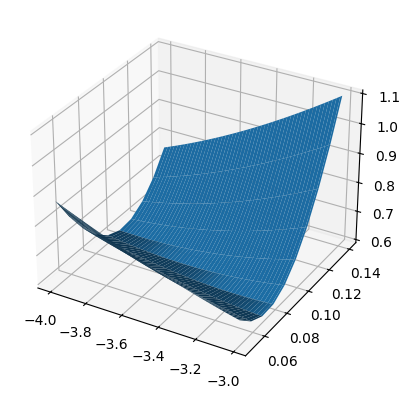

In [19]:
x = df_3d.columns
y = df_3d.index
X,Y = np.meshgrid(x,y)
Z = df_3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

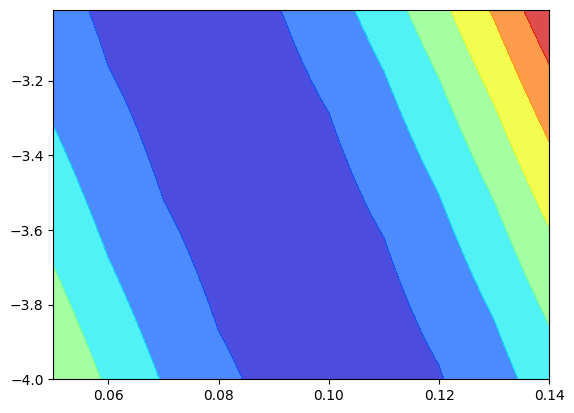

In [20]:
x = df_3d.columns
y = df_3d.index
X,Y = np.meshgrid(x,y)
Z = df_3d
plt.contourf(Y, X, Z, alpha=0.7, cmap=plt.cm.jet)

## Bonus: Optimizando los parámetros

Esta sección es opcional.

Vamos a utilizar el método del gradiente descendente para calcular los valores optimos de $w,b$.

Para esto tenemos que calcular el gradiente para $w,b$ con respecto de la función J (esta es la que hemos gráficado), sus funciones son

$$ \frac{\partial}{\partial w}J\left(w,b\right)=\frac{1}{m}\sum_{i=1}^{m}\left(f_{w,b}\left(\vec{x}^{(i)}\right)-y^{(i)}\right)x^{(i)} $$

$$ \frac{\partial}{\partial b}J\left(w,b\right)=\frac{1}{m}\sum_{i=1}^{m}\left(f_{w,b}\left(\vec{x}^{(i)}\right)-y^{(i)}\right)$$

Las funciones respectivas en python serían

In [21]:
def delta_j_w(w, b):
    train['sigmoid'] = 1/(1+np.exp(-(train['BMI']*w+b)))
    train['partial_loss'] = (train['sigmoid']-train['Outcome'])*train['BMI']
    derivative = train['partial_loss'].mean()
    return(derivative) 

def delta_j_b(w, b):
    train['sigmoid'] = 1/(1+np.exp(-(train['BMI']*w+b)))
    train['partial_loss'] = (train['sigmoid']-train['Outcome'])
    derivative = train['partial_loss'].mean()
    return(derivative) 

Damos valores iniciales a $w,b$

In [22]:
w_0 = 0.09
b_0 = -3.57

Empezamos a iterar hasta obtener valores que no varíen tanto

In [23]:
alpha_w = 0.001
alpha_b = 0.1

w_new = w_0 - alpha_w * delta_j_w(w_0, b_0)
b_new = b_0 - alpha_b * delta_j_b(w_0, b_0)

w_0 = w_new
b_0 = b_new

print(w_0, b_0)

0.09003931387081546 -3.5699779819514177


In [24]:
# valores optimos de sklearn (más abajo la explicación)
# w = 0.09351691
# b = -3.68596089

Ahora vamos a hacer lo mismo pero mucho más rápido con sklear

In [25]:
from sklearn.linear_model import LogisticRegression

# definiendo input y output
X_train = np.array(train['BMI']).reshape((-1, 1))
Y_train = np.array(train['Outcome'])

# creando modelo
model = LogisticRegression()
model.fit(X_train, Y_train)

# imprimiendo parametros
print(f"intercepto (b): {model.intercept_}")
print(f"pendiente (w): {model.coef_}")

intercepto (b): [-3.68596972]
pendiente (w): [[0.09351712]]
